In [5]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

In [6]:
import nibabel as nib
import nilearn
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
import re
import os
import numpy as np
import pandas as pd
import pickle as pkl
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import multiprocessing as mp
from functools import partial
import copy

%matplotlib inline

In [7]:
from utils import apply_warp

## Model specifications

### Model 0:
- SS
- FS
- Go


### Model 1:
- Response_left
- Response_right

In [8]:
def make_first_level_model_fn(sub, ses, task, smoothing_fwhm, model_n, space, save_dir_name='../derivatives/glm_nilearn/subject_level_model'):
    smoothing_fwhm = str(smoothing_fwhm).replace('.', 'p')
    return os.path.join(save_dir_name, f'sub-{sub}/ses-{ses}/func/fwhm-{smoothing_fwhm}/model-{model_n}/sub-{sub}_ses-{ses}_task-{task}_space-{space}_desc-first-level-model.pkl')


## load
def load_first_level_model(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as f:
            first_level_model = pkl.load(f)  # protocol=4 required due to size of pkl
        return first_level_model
    else:
        print(f'{fn} does not exist...')
        return 0
    
def fit_first_level_model(sub, ses, task, model_n=0, space='MNI152NLin2009cAsym', include_physio=True, n_jobs=20, smoothing_fwhm=4.5, 
                          use_susan_presmoothed_data=True,
                          save_model=True, save_dir_name='subject_level_model',
                          overwrite=False, return_model=True):
    # check for existing model
    smoothing_fwhm_str = str(smoothing_fwhm).replace('.', 'p')
    save_fn = make_first_level_model_fn(sub, ses, task, smoothing_fwhm, model_n, space, save_dir_name) # f'../derivatives/{save_dir_name}/sub-{sub}/ses-{ses}/func/fwhm-{smoothing_fwhm_str}/model-{model_n}/sub-{sub}_ses-{ses}_task-{task}_space-{space}_desc-first-level-model.pkl'
    if os.path.exists(save_fn) and not overwrite:
        print(f'Model {model_n} {sub} {ses} {task} {smoothing_fwhm} already fit! Returning pre-fit model...')
        if return_model:
            return load_first_level_model(save_fn)
        else:
            return 0
    
    event_fns = sorted(glob.glob(f'../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_events.tsv'))
#     regressor_fns = sorted(glob.glob(f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_desc-model-regressors.tsv'))
    confounds_fns = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_desc-confounds_timeseries.tsv'))
    
    # fix this for susan presmoothed data
    if use_susan_presmoothed_data:
        smoothing_fwhm=None
        func_fns = sorted(glob.glob(f'../derivatives/susan_smoothed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_space-{space}_desc-preproc_bold_smoothed_fwhm-{smoothing_fwhm_str}.nii.gz'))
    else:
        func_fns = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_space-{space}_desc-preproc_bold.nii.gz'))
        
    run_flms = []
    run_events = []
    run_funcs = []
    run_confounds = []
    
    for run, (event_fn,  func_fn, confounds_fn) in enumerate(zip(event_fns, func_fns, confounds_fns)):    
        # Merge events with trial-by-trial regressors
        events = pd.read_csv(event_fn, sep='\t', index_col=None)  # Onsets & event types
        events['duration'] = 0.001  # stick functions
        if model_n == 0:
            events = events.loc[events.trial_type.isin(['ss', 'fs', 'go'])]
        elif model_n == 1:
            events = events.loc[events.trial_type.isin(['response_left', 'response_right'])]
        events = events[['onset', 'trial_type', 'duration']]
        
        run_events.append(events)

        # load func
        func = nib.load(func_fn)
        run_funcs.append(func)

        # get confounds
        confounds = pd.read_csv(confounds_fn, sep='\t')[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement']].fillna(method='bfill')
        
        # get retroicor
        if include_physio:
            run_idx = run+1
            retroicor_fn = f'../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run_idx}_desc-retroicor_regressors.tsv'
            if not os.path.exists(retroicor_fn):
                ## take first 20 aCompCor components
                print("No retroicor found, including 20 a_comp_cor components")
                a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
                confounds = pd.concat([confounds, a_comp_cor], axis=1)
            else:
                retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
                retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
                confounds = pd.concat([confounds, retroicor], axis=1)

        run_confounds.append(confounds)
   
    
    # get brain mask
    brain_mask = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-1_space-{space}_desc-brain_mask.nii.gz'
    
    # fit
    flm = FirstLevelModel(t_r=1.38, hrf_model = 'glover + derivative', slice_time_ref=0.5,
                          mask_img=brain_mask, smoothing_fwhm=smoothing_fwhm,
                          n_jobs=n_jobs, subject_label=sub)
    flm_fitted = flm.fit(run_funcs, events=run_events, confounds=run_confounds)
    
    # save
    if save_model:
        print('saving model to {}'.format(save_fn))
        os.makedirs(os.path.dirname(save_fn), exist_ok=True)
        with open(save_fn, 'wb') as f:
            pkl.dump(flm_fitted, f, protocol=4)  # protocol=4 required due to size of pkl
    
    if return_model:
        return flm_fitted
    else:
        return 0

## Which participants do we have so far?

In [9]:
reg = re.compile('.*sub-(?P<sub>\d+)_ses-sstmsit_task-sst_run-(?P<run>\d).*')

#all_func_files = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses-rlsat/func/sub-*_ses-rlsat_task-rlsat_run-*_space-T1w_desc-preproc_bold.nii.gz'))
all_func_files = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses-sstmsit/func/sub-*_ses-sstmsit_task-sst_run-*_space-T1w_desc-preproc_bold.nii.gz'))
func_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Func file': True}} for x in all_func_files])

all_smoothed_func_files = sorted(glob.glob('../derivatives/susan_smoothed_func/sub-*/ses-sstmsit/func/*_task-sst*'))
susan_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Susan smoothed': True}} for x in all_smoothed_func_files])

all_retroicor_files = sorted(glob.glob('../derivatives/retroicor/sub-*/ses-sstmsit/func/sub-*_ses-sstmsit_task-sst_run-*_desc-retroicor_regressors.tsv'))
retroicor_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Retroicor': True}} for x in all_retroicor_files])

all_event_files = sorted(glob.glob('../derivatives/event_files/sub-*/ses-sstmsit/func/sub-*_ses-sstmsit_task-sst_run-*_events.tsv'))
event_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Events': True}} for x in all_event_files])

# all_behavior_files = sorted(glob.glob('../derivatives/behavior/sub-*/ses-sstmsit/func/sub-*_ses-rlsat_task-rlsat*'))
# behav_file_df = pd.DataFrame([{**reg.match(x).groupdict(), **{'Behavior model': True}} for x in all_behavior_files])

combined_df = pd.merge(pd.merge(pd.merge(func_file_df, susan_file_df, on=['sub', 'run'], how='outer'), 
                                         retroicor_file_df,on=['sub', 'run'], how='outer'), 
                                event_file_df, on=['sub', 'run'], how='outer')
combined_df = combined_df.set_index(['sub', 'run']).fillna(False)
combined_df['Complete'] = combined_df.apply(np.sum, axis=1) == 4

with pd.option_context('display.max_rows', 10000):
    display(combined_df.sort_index())

Func file  Susan smoothed  Retroicor  Events  Complete
sub run                                                        
002 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
003 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
004 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
005 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
006 1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
007 1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
008 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
009 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
010 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
011 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
012 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
013 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       True    True      True
    2         True            True       True    True      True
    2         True            True       True    True      True
014 1         True            True       True    True      True
    1         True            True       True    True      True
    1         True            True       

In [10]:
to_fit = [(x, 'sstmsit', 'sst') for x in combined_df.loc[combined_df['Func file']].reset_index()['sub'].unique()]
to_fit

[('002', 'sstmsit', 'sst'),
 ('003', 'sstmsit', 'sst'),
 ('004', 'sstmsit', 'sst'),
 ('005', 'sstmsit', 'sst'),
 ('006', 'sstmsit', 'sst'),
 ('007', 'sstmsit', 'sst'),
 ('008', 'sstmsit', 'sst'),
 ('009', 'sstmsit', 'sst'),
 ('010', 'sstmsit', 'sst'),
 ('011', 'sstmsit', 'sst'),
 ('012', 'sstmsit', 'sst'),
 ('013', 'sstmsit', 'sst'),
 ('014', 'sstmsit', 'sst'),
 ('015', 'sstmsit', 'sst'),
 ('016', 'sstmsit', 'sst'),
 ('017', 'sstmsit', 'sst'),
 ('018', 'sstmsit', 'sst'),
 ('019', 'sstmsit', 'sst'),
 ('020', 'sstmsit', 'sst'),
 ('021', 'sstmsit', 'sst'),
 ('023', 'sstmsit', 'sst'),
 ('024', 'sstmsit', 'sst'),
 ('025', 'sstmsit', 'sst'),
 ('026', 'sstmsit', 'sst'),
 ('027', 'sstmsit', 'sst'),
 ('029', 'sstmsit', 'sst'),
 ('031', 'sstmsit', 'sst'),
 ('032', 'sstmsit', 'sst'),
 ('033', 'sstmsit', 'sst'),
 ('034', 'sstmsit', 'sst'),
 ('035', 'sstmsit', 'sst'),
 ('037', 'sstmsit', 'sst'),
 ('038', 'sstmsit', 'sst'),
 ('039', 'sstmsit', 'sst'),
 ('040', 'sstmsit', 'sst'),
 ('041', 'sstmsit', 

## Fit

In [7]:
# Fit
save_dir_name = '../derivatives/glm_nilearn/subject_level_model'
space = 'T1w'

def fit_glm(sub,ses,task, model_n, smoothing_fwhm, space='T1w'):
    print(sub)
    out = fit_first_level_model(sub, ses, task, model_n=model_n, space=space, overwrite=False, use_susan_presmoothed_data=True, smoothing_fwhm=smoothing_fwhm, save_dir_name=save_dir_name, return_model=False)
    return out


for model_n in [0, 1]: 
    for smoothing_fwhm in [4.5, 1.5]:
        _ = joblib.Parallel(n_jobs=1)(joblib.delayed(fit_glm)(sub, ses, task, model_n=model_n, smoothing_fwhm=smoothing_fwhm) for sub,ses,task in to_fit)

002


/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


saving model to ../derivatives/glm_nilearn/subject_level_model/sub-002/ses-sstmsit/func/fwhm-4p5/model-0/sub-002_ses-sstmsit_task-sst_space-T1w_desc-first-level-model.pkl
003
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-003/ses-sstmsit/func/fwhm-4p5/model-0/sub-003_ses-sstmsit_task-sst_space-T1w_desc-first-level-model.pkl
004
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-004/ses-sstmsit/func/fwhm-4p5/model-0/sub-004_ses-sstmsit_task-sst_space-T1w_desc-first-level-model.pkl
005
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-005/ses-sstmsit/func/fwhm-4p5/model-0/sub-005_ses-sstmsit_task-sst_space-T1w_desc-first-level-model.pkl
006
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-006/ses-sstmsit/func/fwhm-4p5/model-0/sub-006_ses-sstmsit_task-sst_space-T1w_desc-first-level-model.pkl
007
saving model to ../derivatives/glm_nilearn/subject_level_model/sub-007/ses-sstmsit/func/fwhm-4p5/model-0/sub-007_ses-sstmsit_

IndexError: list index out of range

## Compute & warp contrasts

In [6]:
def compute_contrasts(comb, contrast_mapping, model_n, smoothing_fwhm, space='T1w', save_dir_name='../derivatives/glm_nilearn/subject_level_model'):
    sub,ses,task = comb
    # check for existing model
    smoothing_fwhm_str = str(smoothing_fwhm).replace('.', 'p')
    flm_fn = make_first_level_model_fn(sub, ses, task, smoothing_fwhm, model_n, space, save_dir_name=save_dir_name)
    if not os.path.exists(flm_fn):
        raise(IOError(f"Model doesn''t exist! expected to find it at {flm_fn}"))
        
    # check for existing output fns
    stat_map_name = 'z_score'
    to_compute = {} #copy.copy(contrast_mapping)
    for contrast_name, contrast in contrast_mapping.items():
        save_fn = flm_fn.replace('desc-first-level-model.pkl', f'desc-contrast-{contrast_name}_{stat_map_name}.nii.gz')
        if not os.path.exists(save_fn):
            # skip this one
            to_compute[contrast_name] = contrast
    
    if len(to_compute) == 0:
        print('All contrasts already computed')
        return 0
        
    # load first level models & make contrast maps
    first_level_model = load_first_level_model(flm_fn)

    for contrast_name, contrast in to_compute.items():
        
        # save all stat maps
        stat_maps = first_level_model.compute_contrast(contrast, output_type='all')
        for stat_map_name, stat_map in stat_maps.items():
            save_fn = flm_fn.replace('desc-first-level-model.pkl', f'desc-contrast-{contrast_name}_{stat_map_name}.nii.gz')
            stat_map.to_filename(save_fn)
            
            # warp
            stat_map_warped = apply_warp(save_fn, sub)            
            # move
            os.rename(stat_map_warped, save_fn.replace('space-T1w', 'space-MNI152NLin2009cAsym'))
    
    return 0


save_dir_name = '../derivatives/glm_nilearn/subject_level_model'
space = 'T1w'

## weirdly this doesn't work with joblib, so move to multiprocess
for model_n in [0,1]: #, 1]: #,2]:
    
    if model_n == 0:
        contrast_mapping = {'fs': 'fs',
                            'ss': 'ss',
                            'go': 'go',
                            'fs-go': 'fs-go',
                            'ss-go': 'ss-go',
                            'fs-ss': 'fs-ss',
                            }
    elif model_n == 1:
        contrast_mapping = {'response_left': 'response_left',
                            'response_right': 'response_right',
                            'left-right': 'response_left - response_right'
                           }
        
    for smoothing_fwhm in [4.5, 1.5]:
        with mp.Pool(12) as p:
            p.map(partial(compute_contrasts, contrast_mapping=contrast_mapping, model_n=model_n, smoothing_fwhm=smoothing_fwhm), to_fit)
#         for comb in to_fit:
#             compute_contrasts(comb, contrast_mapping=contrast_mapping, model_n=model_n, smoothing_fwhm=smoothing_fwhm)

All contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computed







All contrasts already computed
All contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computed



All contrasts already computed
All contrasts already computed
All contrasts already computed


All contrasts already computed
All contrasts already computedAll contrasts already computed

All contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computedAll contrasts already computed


All contrasts al

In [19]:
# all_dirs = sorted(glob.glob('../derivatives/glm_nilearn/subject_level_model/sub*/ses-rlsat/func/fwhm-*'))

# for dir_ in all_dirs:
#     os.rename(dir_, dir_.replace('1.5', '1p5').replace('4.5', '4p5'))

## Group level model

In [17]:
model_n

NameError: name 'model_n' is not defined

In [10]:
# fwhm = 1.5
# fwhm_str = str(fwhm).replace('.', 'p')

imgs = sorted(glob.glob(f'../derivatives/glm_nilearn/subject_level_model/sub-*/ses-sstmsit/func/fwhm-*/model-*/*task-sst*MNI*desc-contrast-*_effect_size*'))
regex = re.compile('.*/sub-(?P<sub>\d+)/.*/fwhm-(?P<fwhm>\S+)/model-(?P<model_n>\d)/sub-.*_desc-contrast-(?P<contrast_name>\S+)_effect_size.nii.gz')

df = pd.DataFrame({'effects_map_path':imgs})
df['subject_label'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['sub'])
df['fwhm'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['fwhm'])
df['model_n'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['model_n'])
df['map_name'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['contrast_name'])
df.head()

effects_map_path subject_label fwhm  \
0  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   
1  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   
2  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   
3  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   
4  ../derivatives/glm_nilearn/subject_level_model...           002  1p5   

  model_n map_name  
0       0    fs-go  
1       0    fs-ss  
2       0       fs  
3       0       go  
4       0    ss-go

In [18]:
imgs

['../derivatives/glm_nilearn/subject_level_model/sub-002/ses-sstmsit/func/fwhm-1p5/model-0/sub-002_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-fs-go_effect_size.nii.gz',
 '../derivatives/glm_nilearn/subject_level_model/sub-002/ses-sstmsit/func/fwhm-1p5/model-0/sub-002_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-fs-ss_effect_size.nii.gz',
 '../derivatives/glm_nilearn/subject_level_model/sub-002/ses-sstmsit/func/fwhm-1p5/model-0/sub-002_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-fs_effect_size.nii.gz',
 '../derivatives/glm_nilearn/subject_level_model/sub-002/ses-sstmsit/func/fwhm-1p5/model-0/sub-002_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-go_effect_size.nii.gz',
 '../derivatives/glm_nilearn/subject_level_model/sub-002/ses-sstmsit/func/fwhm-1p5/model-0/sub-002_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-ss-go_effect_size.nii.gz',
 '../derivatives/glm_nilearn/subject_level_model/sub-002/ses-sstmsit/fu

In [11]:
def save_second_level_spm(spm, first_level_contrast_name, second_level_contrast_name, fwhm, model_n, save_dir_name='../derivatives/glm_nilearn/group_level_model/ses-sstmsit'):
    fwhm = str(fwhm).replace('.', 'p')
    save_fn = os.path.join(save_dir_name, f'fwhm-{fwhm}/model-{model_n}/firstlevelcontrast-{first_level_contrast_name}_secondlevelcontrast-{second_level_contrast_name}.nii.gz')
    
    if not os.path.exists(os.path.dirname(save_fn)):
        os.makedirs(os.path.dirname(save_fn))
    
    spm.to_filename(save_fn)
    nilearn.image.math_img('-nii', nii=spm).to_filename(save_fn.replace('.nii.gz', '-neg.nii.gz'))

In [12]:
def fit_second_level_models(first_level_contrast, second_level_contrast, fwhm, model_n, df):
    print(f'{fwhm} {model_n} {first_level_contrast}')
    df_in = df.loc[(df.map_name==first_level_contrast) & (df.fwhm==str(fwhm).replace('.', 'p')) & (df.model_n==str(model_n))]
    #dm = pd.merge(df_in, parameters[['subject_label', 'B0.SPD-ACC_z']]) #, 'V0.SPD-ACC_z']])
    df_in['intercept'] = 1

    dm_in = df_in[['intercept']]
#     if first_level_contrast == 'SPD-ACC':
#         dm_in = dm[['intercept', 'B0.SPD-ACC_z']] #, 'V0.SPD-ACC_z']]
#     else:
#         dm_in = dm[['intercept']]
    slm = SecondLevelModel()
    slm_fitted = slm.fit(second_level_input=df_in.effects_map_path.values.tolist(), design_matrix=dm_in)

    # Intercept, threshold covariance, urgency covariance
    cmap = slm_fitted.compute_contrast('intercept', output_type='z_score')
    save_second_level_spm(cmap, first_level_contrast_name=first_level_contrast, second_level_contrast_name=second_level_contrast, fwhm=fwhm, model_n=model_n)

In [13]:
import itertools
all_combs = list(itertools.product(df.map_name.unique().tolist(), ['intercept'], [1.5], [0]))

_ = joblib.Parallel(n_jobs=10, verbose=1)(joblib.delayed(fit_second_level_models)(first_level_contrast, second_level_contrast, fwhm, model_n, df=df) for first_level_contrast,second_level_contrast,fwhm,model_n in all_combs)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   6 out of   6 | elapsed:  1.3min finished


In [14]:
all_combs

[('fs-go', 'intercept', 1.5, 0),
 ('fs-ss', 'intercept', 1.5, 0),
 ('fs', 'intercept', 1.5, 0),
 ('go', 'intercept', 1.5, 0),
 ('ss-go', 'intercept', 1.5, 0),
 ('ss', 'intercept', 1.5, 0)]

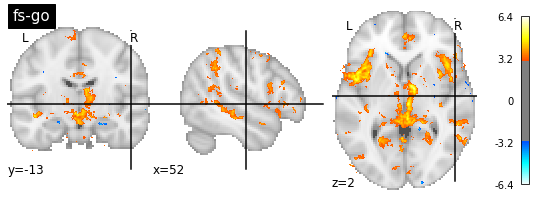

In [25]:
first_level_contrast, second_level_contrast, fwhm, _ = all_combs[0]
fwhm = str(fwhm).replace('.', 'p')
z_map = nib.load(f'../derivatives/glm_nilearn/group_level_model/ses-sstmsit/fwhm-{fwhm}/model-0/firstlevelcontrast-{first_level_contrast}_secondlevelcontrast-{second_level_contrast}.nii.gz')
# plotting.view_img(z_map, threshold=3.1, title=first_level_contrast)
plotting.plot_stat_map(z_map, threshold=3.1, title=first_level_contrast, cut_coords=[52, -13, 2])
plt.gcf().savefig('./sst-fs_go.pdf', bbox_inches='tight')


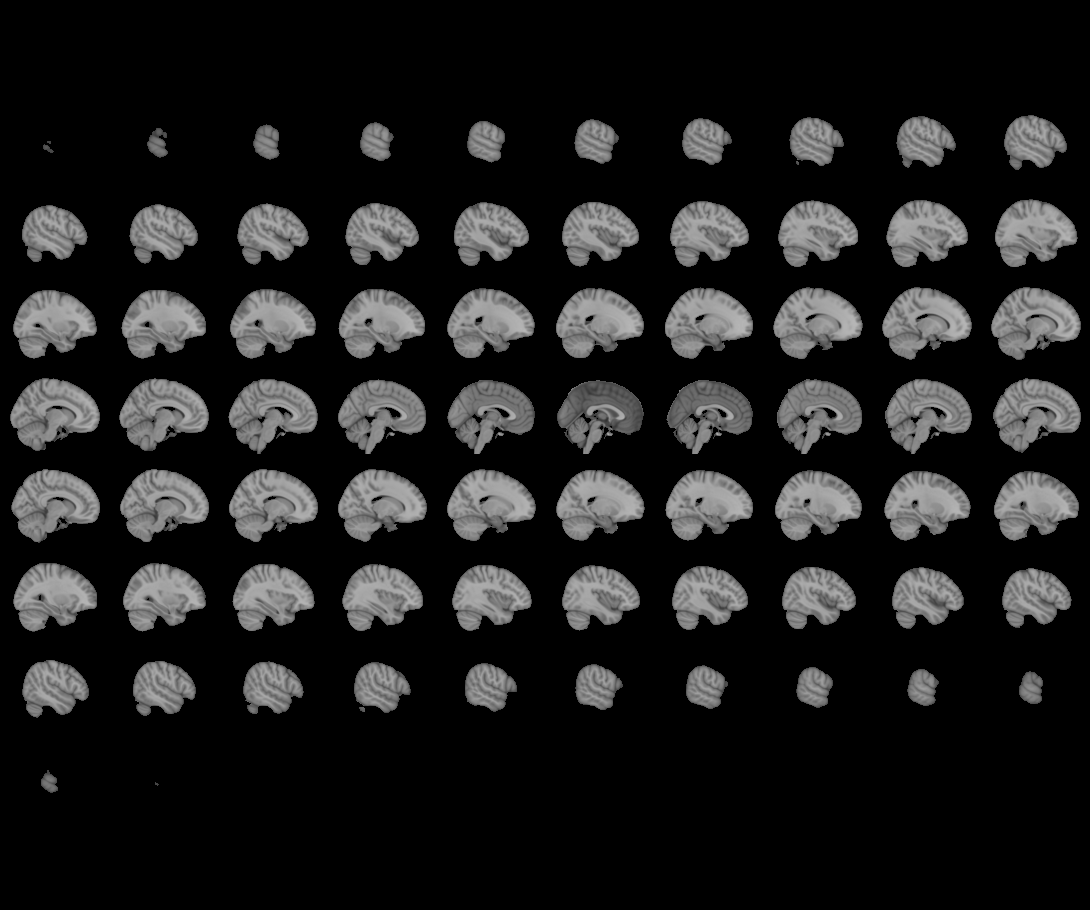
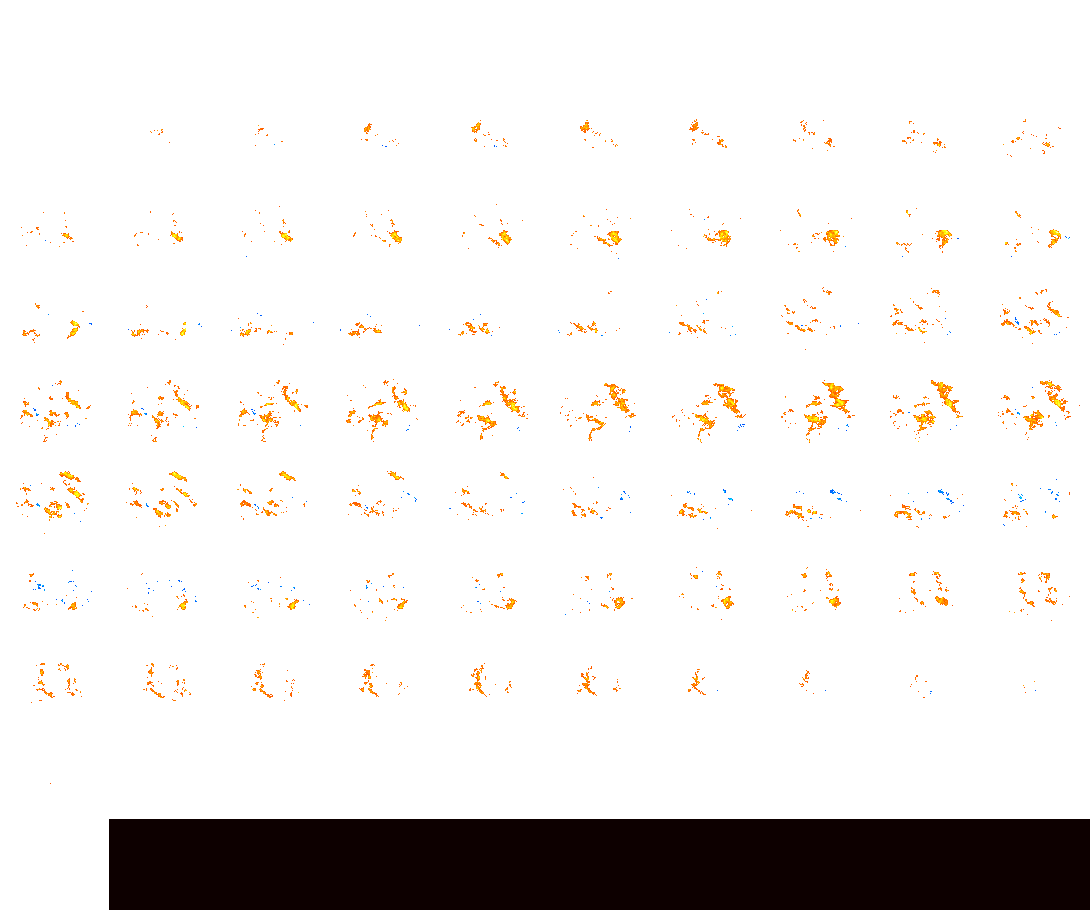

In [15]:
plotting.view_img(z_map, threshold=3.1, title=first_level_contrast)


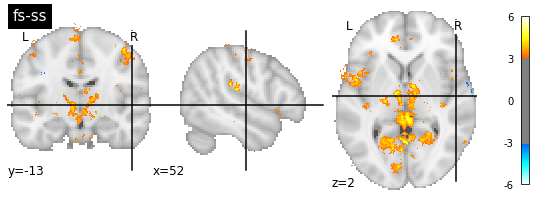

In [19]:
first_level_contrast, second_level_contrast, fwhm, _ = all_combs[1]
fwhm = str(fwhm).replace('.', 'p')

z_map = nib.load(f'../derivatives/glm_nilearn/group_level_model/ses-sstmsit/fwhm-{fwhm}/model-0/firstlevelcontrast-{first_level_contrast}_secondlevelcontrast-{second_level_contrast}.nii.gz')
plotting.plot_stat_map(z_map, threshold=3.1, title=first_level_contrast, cut_coords=[52, -13, 2])
plt.gcf().savefig('./sst-fs-ss.pdf', bbox_inches='tight')


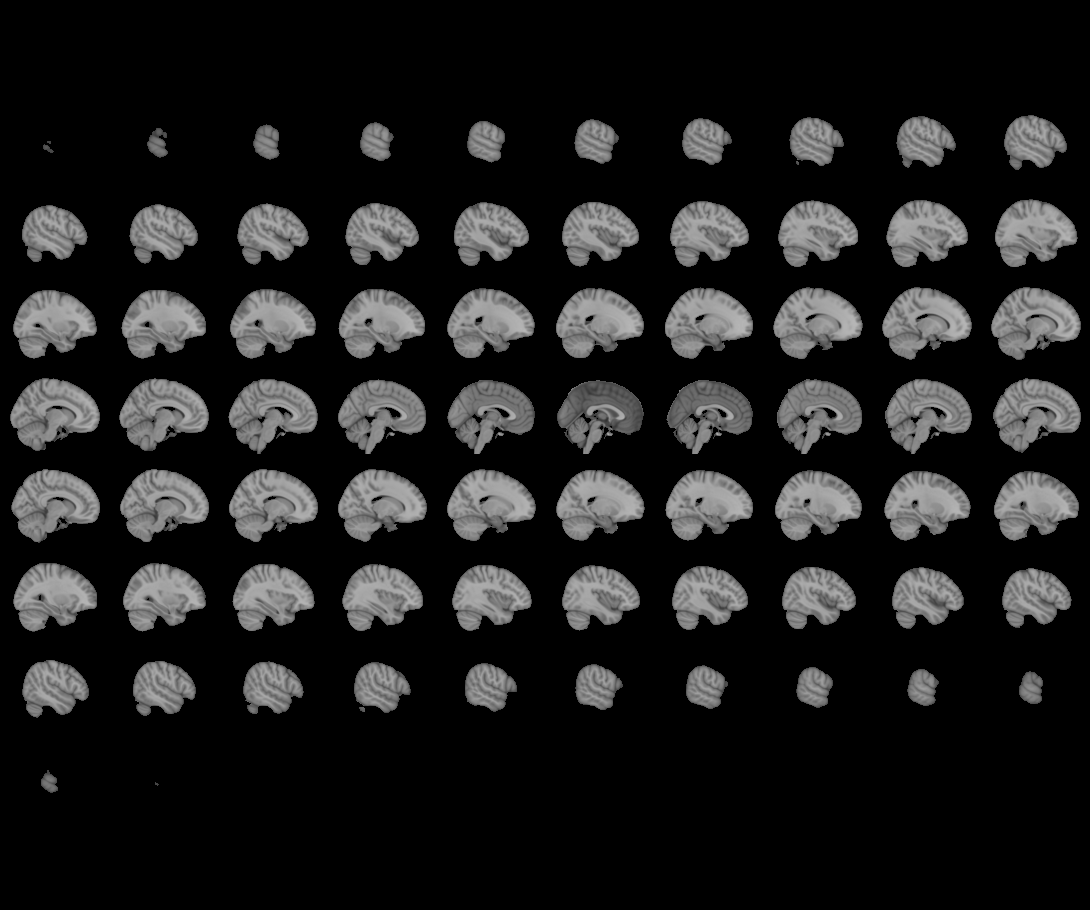
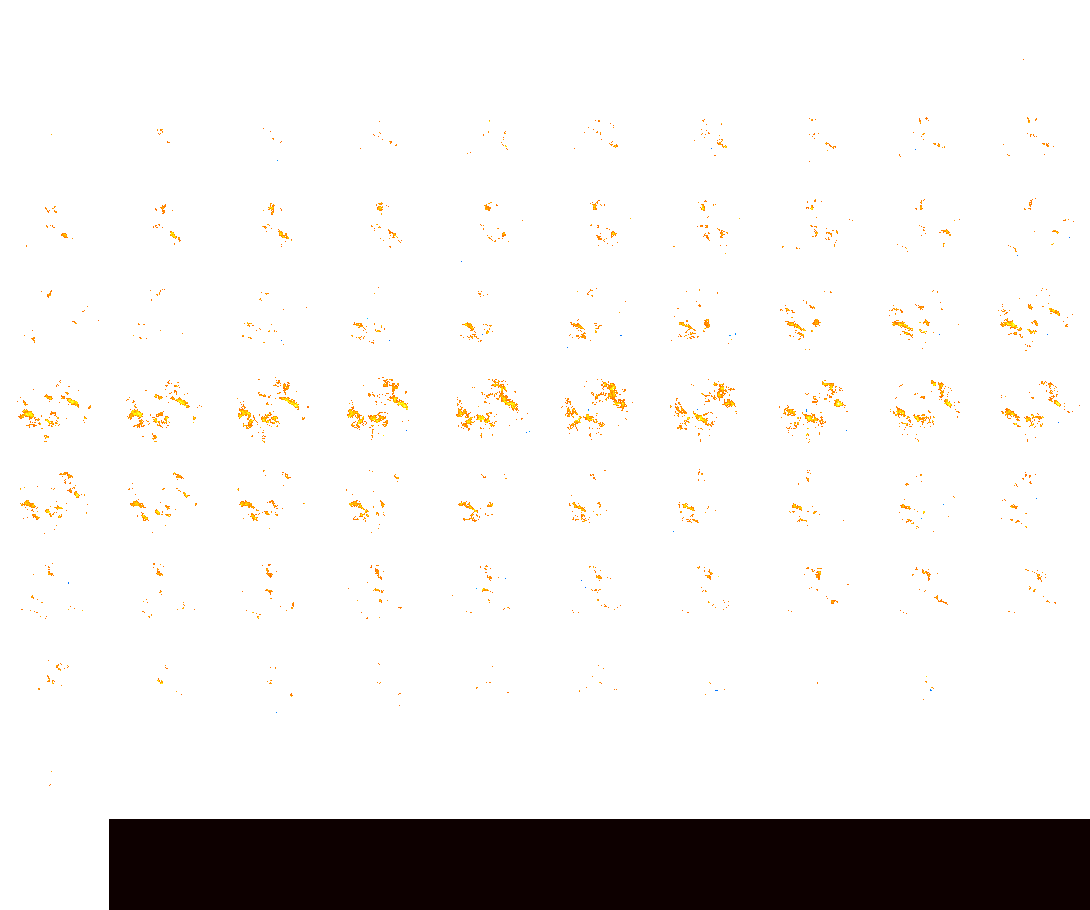

In [20]:
plotting.view_img(z_map, threshold=3.1, title=first_level_contrast)


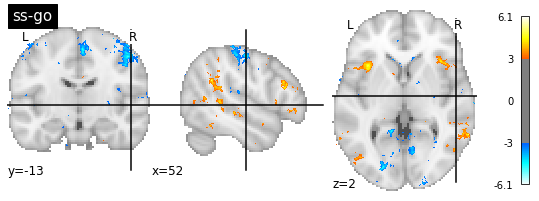

In [21]:
first_level_contrast, second_level_contrast, fwhm, _ = all_combs[-2]
fwhm = str(fwhm).replace('.', 'p')
z_map = nib.load(f'../derivatives/glm_nilearn/group_level_model/ses-sstmsit/fwhm-{fwhm}/model-0/firstlevelcontrast-{first_level_contrast}_secondlevelcontrast-{second_level_contrast}.nii.gz')
plotting.plot_stat_map(z_map, threshold=3.1, title=first_level_contrast, cut_coords=[52, -13, 2])
plt.gcf().savefig('./sst-ss-go.pdf', bbox_inches='tight')


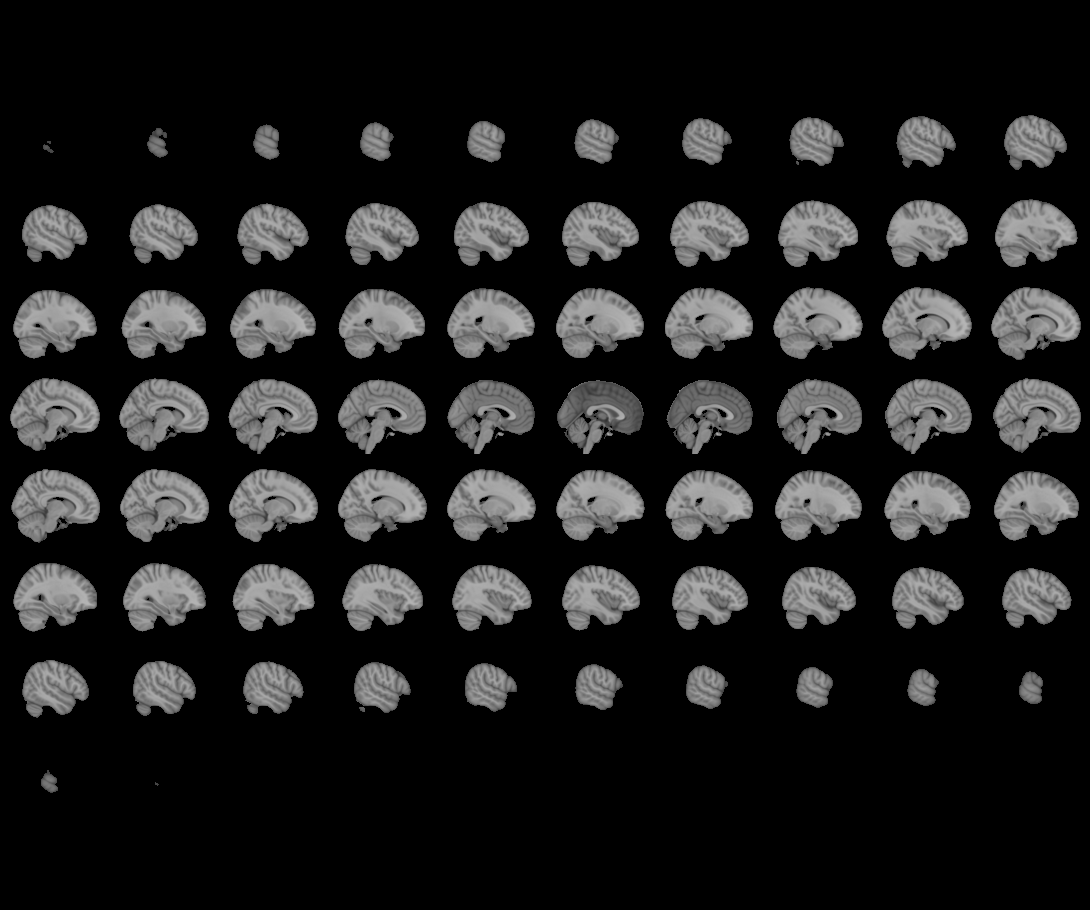
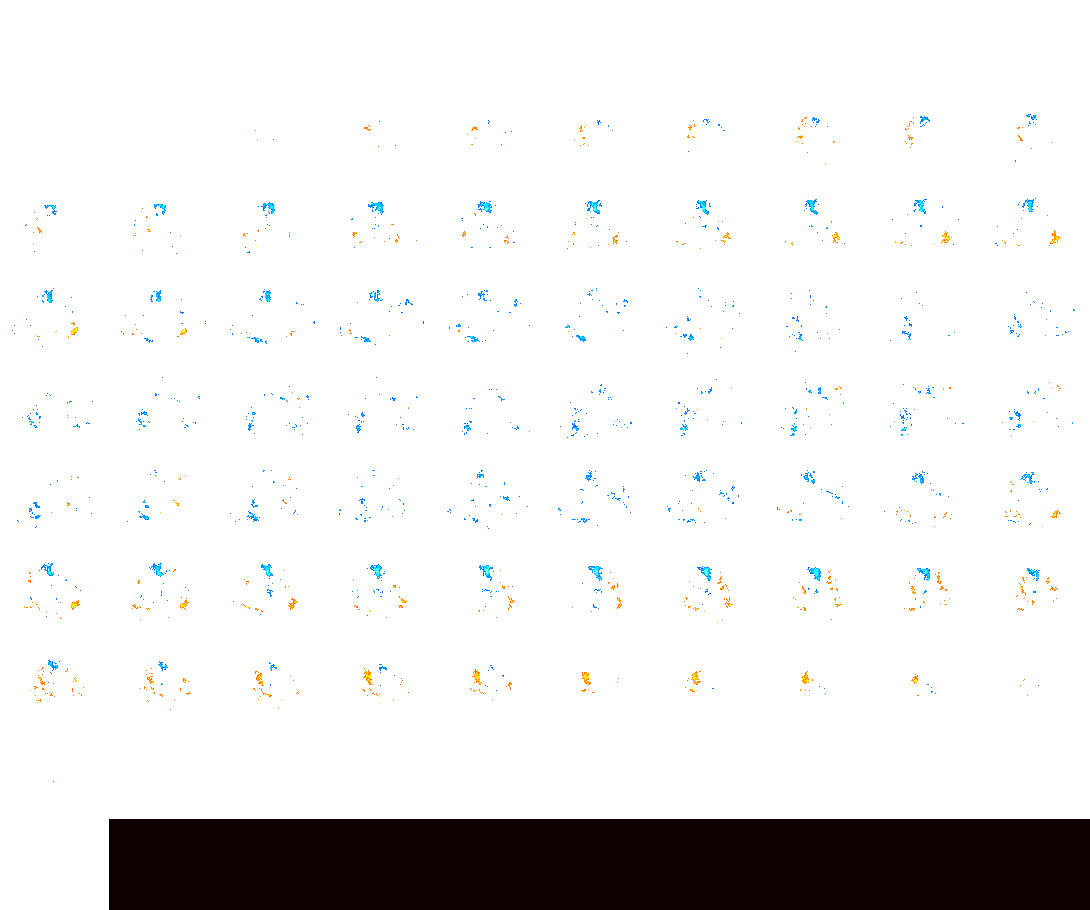

In [22]:
plotting.view_img(z_map, threshold=3.1, title=first_level_contrast)


In [24]:
# first_level_contrast, second_level_contrast, _, _ = all_combs[-3]
# z_map = nib.load(f'../derivatives/glm_nilearn/group_level_model/ses-sstmsit/fwhm-4p5/model-0/firstlevelcontrast-{first_level_contrast}_secondlevelcontrast-{second_level_contrast}.nii.gz')
# plotting.view_img(z_map, threshold=2.5)

### What's up with the SS contrast?


...or are the Go and FS contrasts weird?

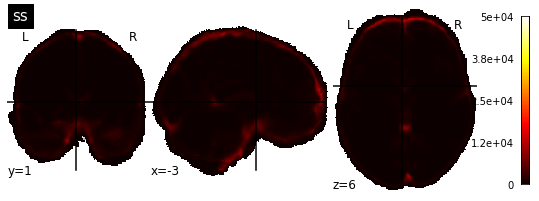

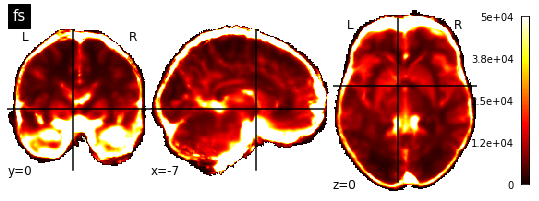

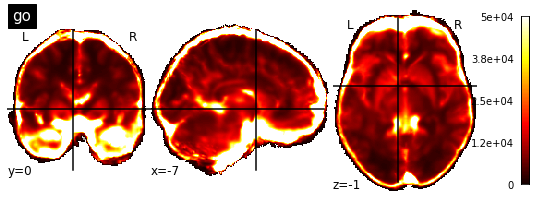

In [169]:
mean_effect_variances = {}
for contrast in ['ss', 'fs', 'go']:
    all_fns = sorted(glob.glob(f'../derivatives/glm_nilearn/subject_level_model/sub-*/ses-sstmsit/func/fwhm-4p5/model-0/sub-*_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-{contrast}_effect_variance.nii.gz'))
    mean_effect_variances[contrast] = nilearn.image.mean_img(all_fns)
    
for key,val in mean_effect_variances.items():
    plotting.plot_stat_map(val, vmax=5e4, title=key)

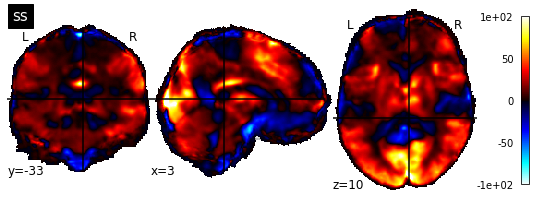

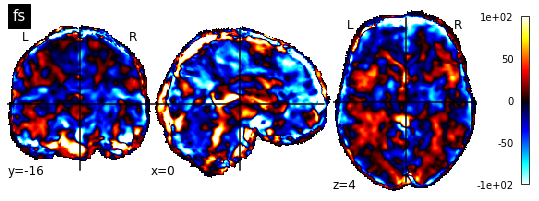

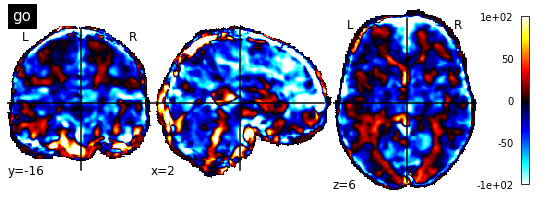

In [172]:
mean_effect_sizes = {}
for contrast in ['ss', 'fs', 'go']:
    all_fns = sorted(glob.glob(f'../derivatives/glm_nilearn/subject_level_model/sub-*/ses-sstmsit/func/fwhm-4p5/model-0/sub-*_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-{contrast}_effect_size.nii.gz'))
    mean_effect_sizes[contrast] = nilearn.image.mean_img(all_fns)

for key,val in mean_effect_sizes.items():
    plotting.plot_stat_map(val, vmax=1e2, title=key)

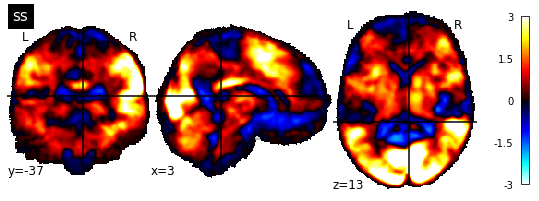

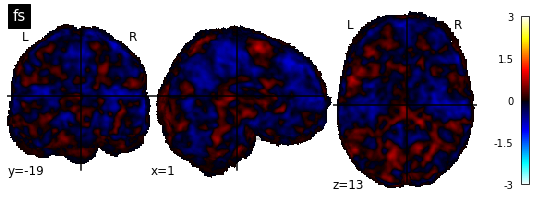

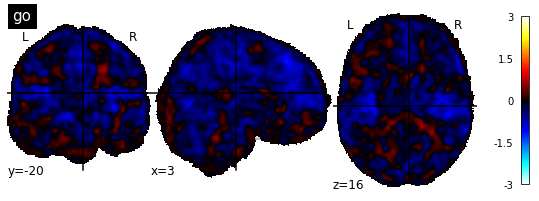

In [171]:
mean_zs = {}
for contrast in ['ss', 'fs', 'go']:
    all_fns = sorted(glob.glob(f'../derivatives/glm_nilearn/subject_level_model/sub-*/ses-sstmsit/func/fwhm-4p5/model-0/sub-*_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-{contrast}_z_score.nii.gz'))
    mean_zs[contrast] = nilearn.image.mean_img(all_fns)
    
for key,val in mean_zs.items():
    plotting.plot_stat_map(val, vmax=3, title=key)

## is there any specific sub which fails with SS, or all subs?

In [150]:
all_fns = sorted(glob.glob('../derivatives/glm_nilearn/subject_level_model/sub-*/ses-sstmsit/func/fwhm-4p5/model-0/sub-*_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-ss_z_score.nii.gz'))
# mean_effect_size_ss = nilearn.image.mean_img(all_fns)

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/plotting/displays.py:667: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


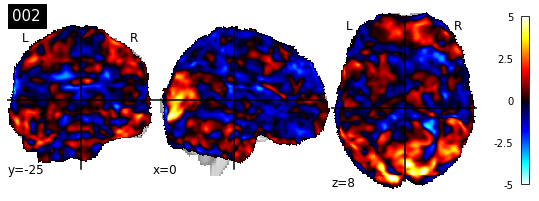

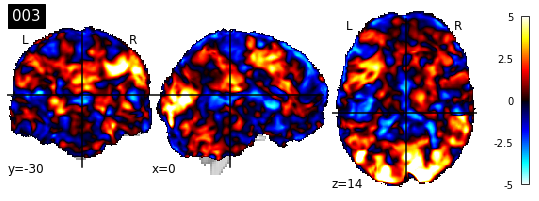

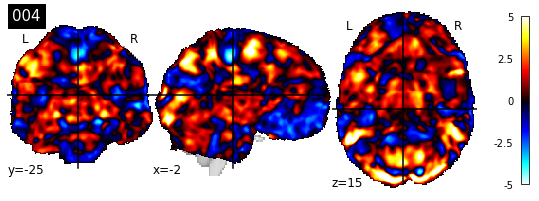

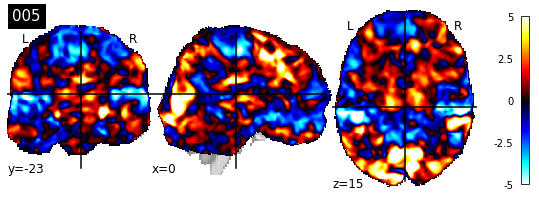

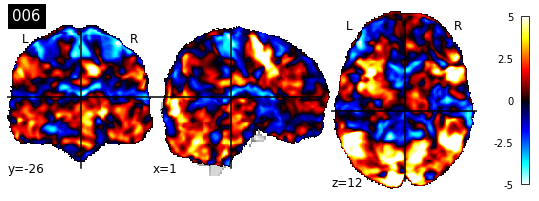

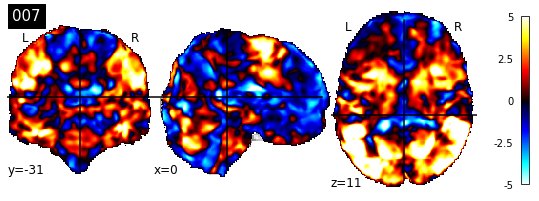

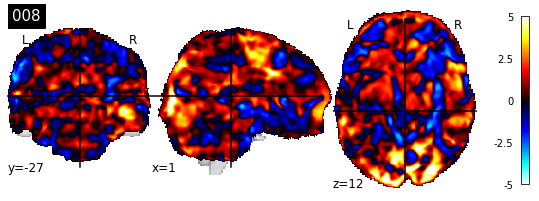

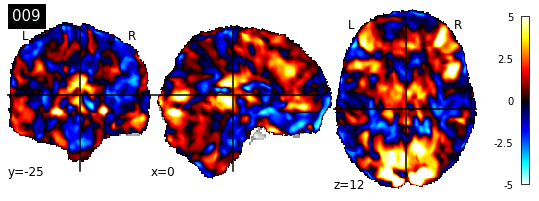

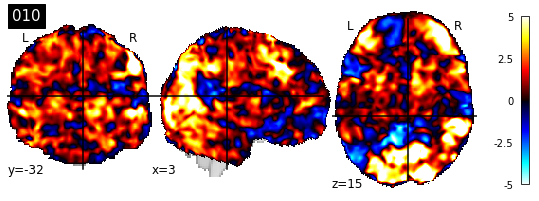

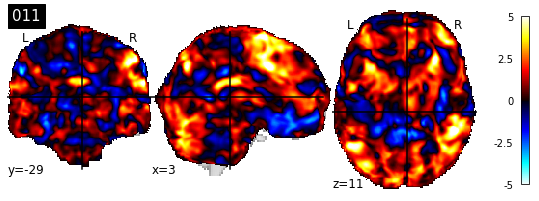

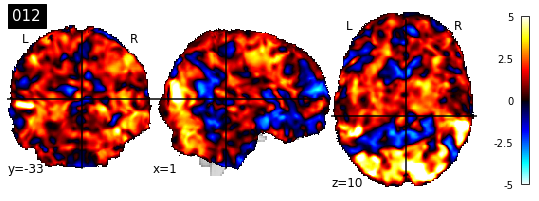

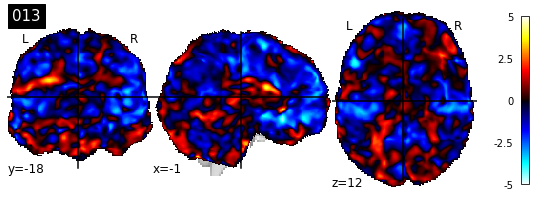

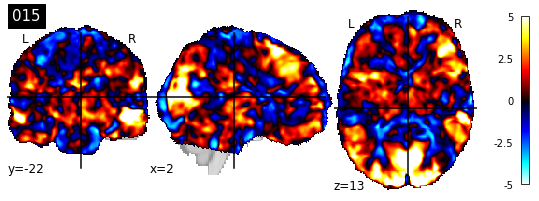

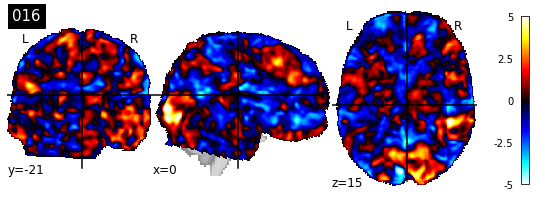

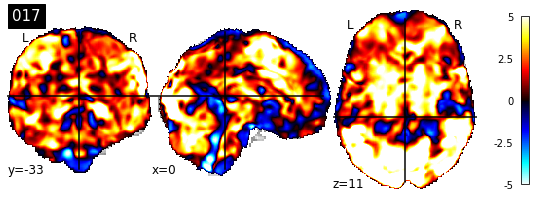

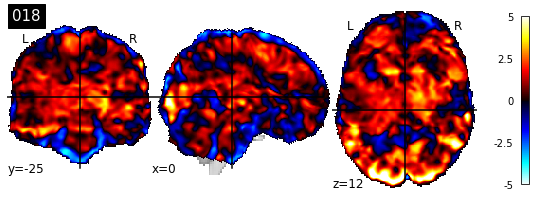

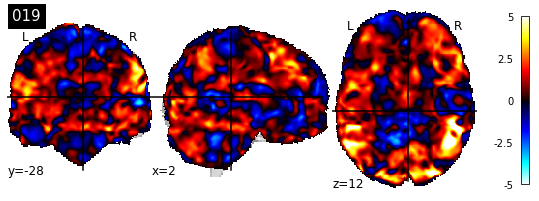

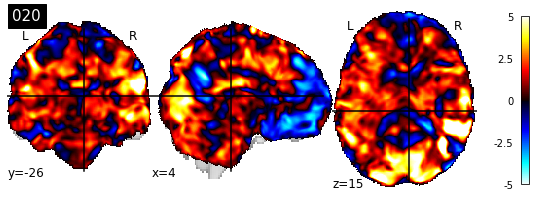

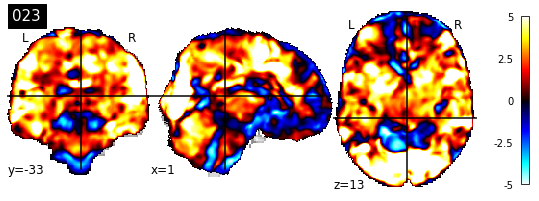

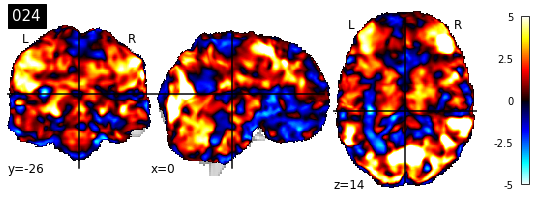

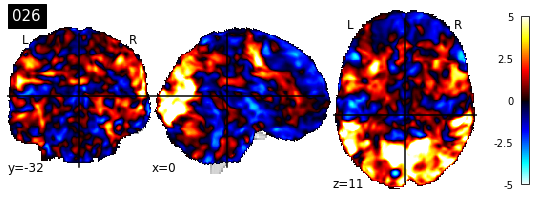

In [151]:
regex = re.compile('.*/sub-(?P<sub>\d+)_ses-sstmsit_task-sst_.*.nii.gz')

for fn in all_fns:
    sub = regex.match(fn).groupdict()['sub']
    plotting.plot_stat_map(nib.load(fn), vmax=5, title=sub)

## failed stops?

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/plotting/displays.py:667: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


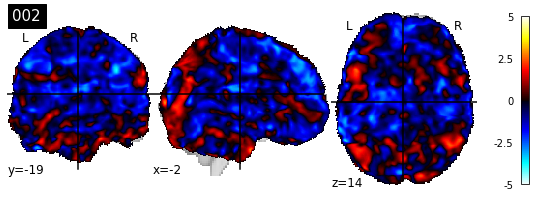

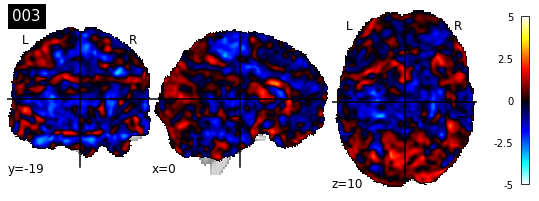

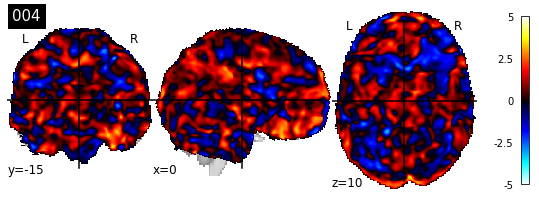

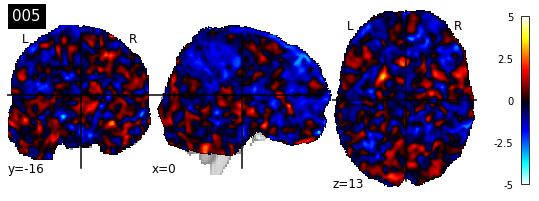

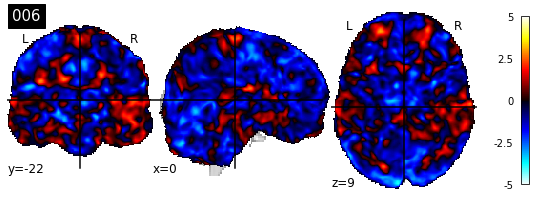

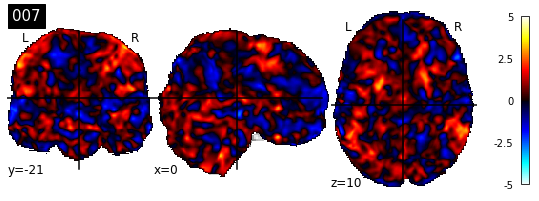

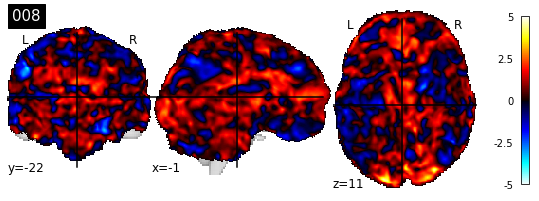

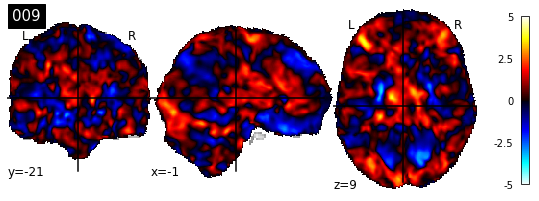

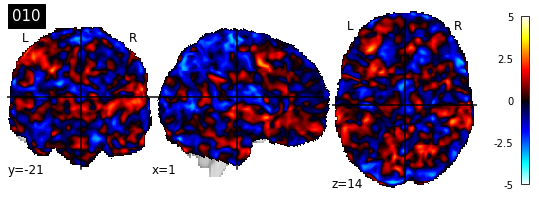

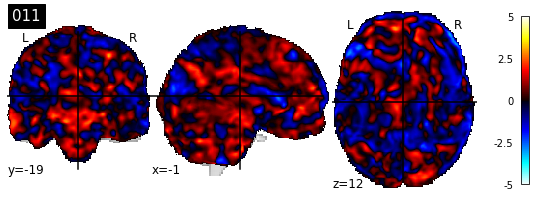

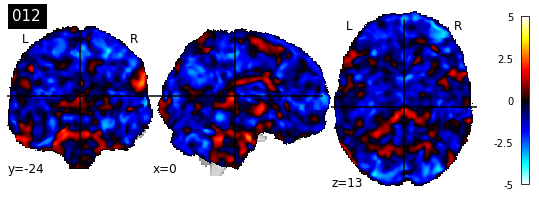

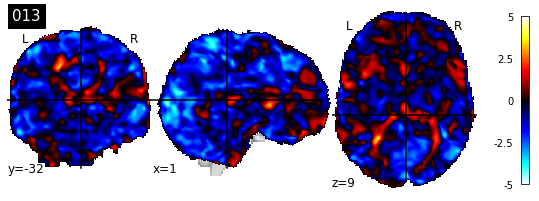

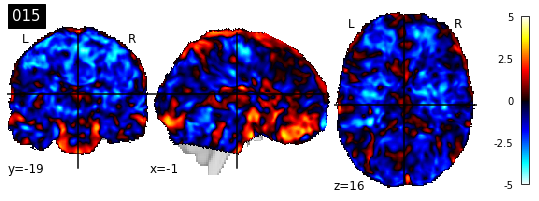

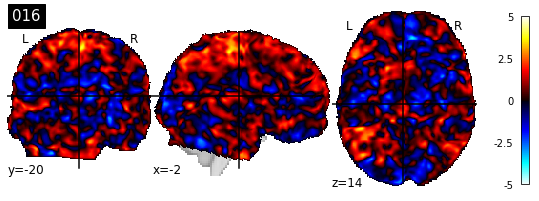

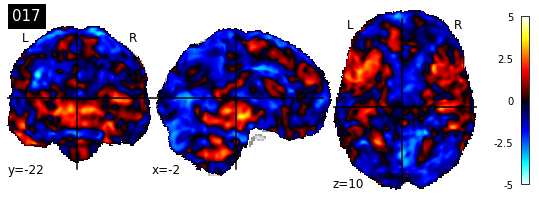

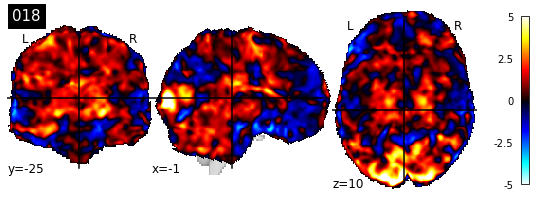

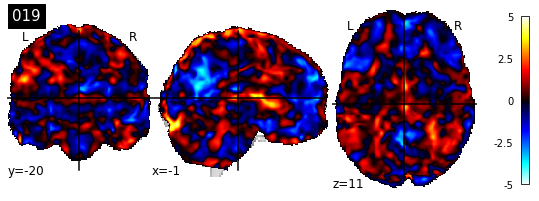

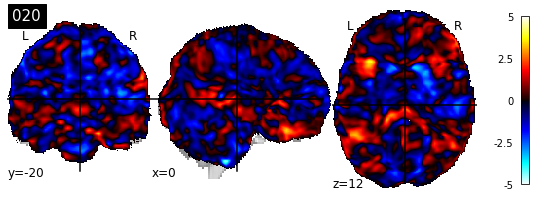

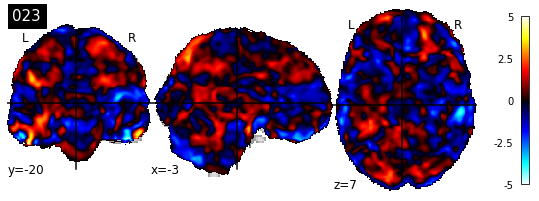

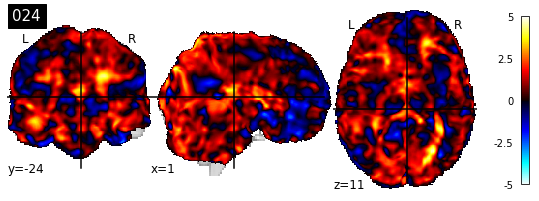

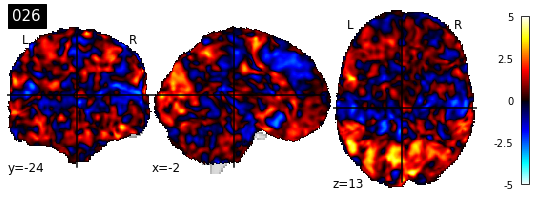

In [210]:
all_fns = sorted(glob.glob('../derivatives/glm_nilearn/subject_level_model/sub-*/ses-sstmsit/func/fwhm-4p5/model-0/sub-*_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-fs_z_score.nii.gz'))
# mean_effect_size_ss = nilearn.image.mean_img(all_fns)

regex = re.compile('.*/sub-(?P<sub>\d+)_ses-sstmsit_task-sst_.*.nii.gz')

for fn in all_fns:
    sub = regex.match(fn).groupdict()['sub']
    plotting.plot_stat_map(nib.load(fn), vmax=5, title=sub)

In [1]:
#all_combs[0]

NameError: name 'all_combs' is not defined

In [11]:
first_level_contrast, second_level_contrast, fwhm, _ =  'response_left-response_right', 'intercept', '1p5', '' #all_combs[0]
first_level_contrast

'response_left-response_right'

In [12]:
first_level_contrast, second_level_contrast, fwhm, _ =  'response_left-response_right', 'intercept', '1p5', '' #all_combs[0]
fwhm = str(fwhm).replace('.', 'p')
z_map = nib.load(f'../derivatives/glm_nilearn/group_level_model/ses-sstmsit/fwhm-{fwhm}/model-1/firstlevelcontrast-{first_level_contrast}_secondlevelcontrast-{second_level_contrast}.nii.gz')
# plotting.view_img(z_map, threshold=3.1, title=first_level_contrast)
plotting.plot_stat_map(z_map, threshold=3.1, title=first_level_contrast, cut_coords=[52, -13, 2])
plt.gcf().savefig('./sst-fs_go.pdf', bbox_inches='tight')

FileNotFoundError: No such file or no access: '../derivatives/glm_nilearn/group_level_model/ses-sstmsit/fwhm-1p5/model-1/firstlevelcontrast-response_left-response_right_secondlevelcontrast-intercept.nii.gz'